## Overhead MNIST Dataset

* Dataset of Satellite images — 
    * Training set of $8,518$ examples
    * Test set of $1,065$ examples. 
    * Number of classes is $4$ with total $9,584$ labels
    * Each example is a $28 \times 28$ grayscale image, associated with a label from $4$ classes. 
    * Each image is $28$ pixels in height and $28$ pixels in width, for a total of $784$ pixels in total. 
    * Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. 
    * This pixel-value is an integer between $0$ and $255$. 
* Each picture contains object variants from sparse edges to single, or multiple, instances of the indicated category.

### Importing Libraries for Manipulating and Visualising Data

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import time

### Loading the Overhead MNIST Dataset
* No need to further splitting of data
* Loads in terms of both training and testing data.

In [2]:
classes = pd.read_csv("classes.csv")
labels = pd.read_csv("labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [3]:
print("Classes shape :" + str(classes.shape))
print("Labels shape:" + str(labels.shape))
print("Test shape:" + str(test.shape))
print("Train shape:" + str(train.shape))

Classes shape :(10, 4)
Labels shape:(9584, 4)
Test shape:(1065, 785)
Train shape:(8519, 785)


In [4]:
classes.head()

,class,label,train_count,test_count
0,car,0,888,112
1,harbor,1,889,111
2,helicopter,2,655,82
3,oil_gas_field,3,888,110
4,parking_lot,4,888,112


In [5]:
labels.head()

,label,class,image,dataset
0,8,stadium,00001.jpg,train
1,3,oil_gas_field,00002.jpg,train
2,0,car,00003.jpg,train
3,6,runway_mark,00004.jpg,train
4,5,plane,00005.jpg,train


In [6]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,86,91,98,97,96,89,76,84,87,...,76,81,80,72,77,83,71,44,53,33
1,3,128,133,129,119,114,128,141,131,133,...,137,129,139,161,128,137,131,125,127,135
2,0,138,117,84,52,38,62,86,75,101,...,63,99,109,83,61,54,75,98,107,108
3,6,105,108,108,109,111,112,107,104,106,...,120,115,105,89,87,98,92,95,89,84
4,5,176,143,109,155,151,149,145,152,156,...,92,85,82,91,80,80,79,79,82,85


In [7]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,198,225,234,229,230,228,214,244,107,...,209,222,211,196,216,206,192,212,242,254
1,1,34,35,30,17,16,22,11,42,137,...,36,41,32,33,34,37,33,36,35,37
2,4,113,176,239,250,247,231,177,181,178,...,70,85,158,189,150,168,148,181,154,54
3,3,151,129,173,182,140,119,120,115,112,...,136,118,126,130,124,119,134,126,121,122
4,7,186,159,233,255,255,227,140,110,113,...,131,149,108,87,120,131,138,137,137,139


### Training and Testing Set

In [8]:
# Training set
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]

# Testing set
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

### Checking for Unknown Values
* There is no unknown value in our datasets. 
* Let's, move to further preprocessing.

In [9]:
c = 'False'
for i in range(0, 785):
    if train.iloc[:, i].isnull().values.any() == True:
        c = True
        break
print("Is any value in training data unknown =", c)

c = 'False'
for i in range(0, 785):
    if test.iloc[:, i].isnull().values.any() == True:
        c = True
        break
print("Is any value in testing data unknown =", c)


Is any value in training data unknown = False
Is any value in testing data unknown = False


* $\texttt{Normalizing}$ the dataset

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

### Visualizing the data

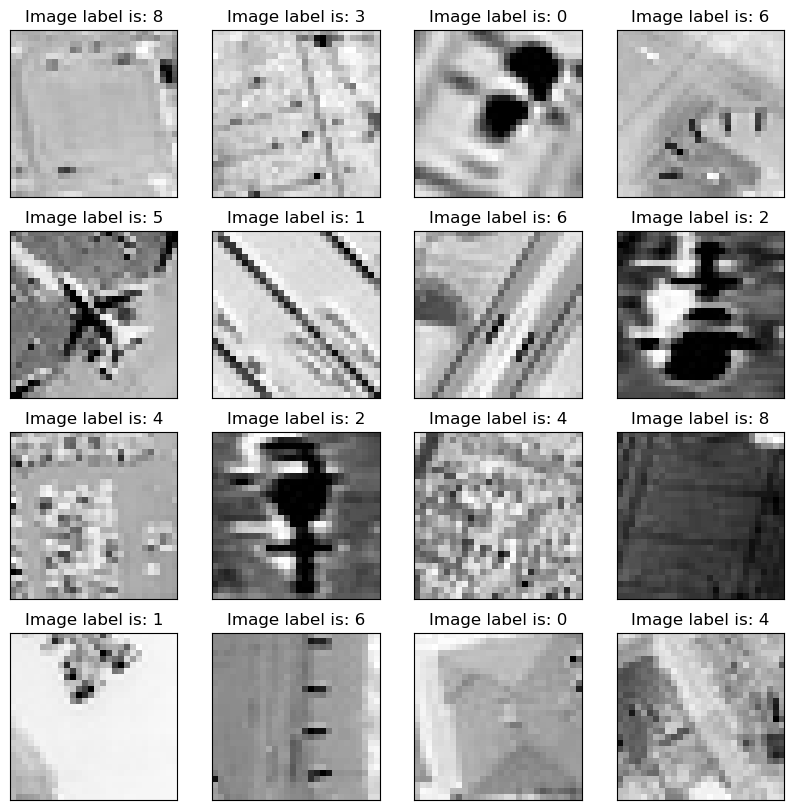

In [11]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(X_train)[i].reshape(28,28), cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(y_train[i]))
plt.show()

### Logistic Regression on Fully Labelled Dataset
* Now let's fit a Logistic Regression model and evaluate it on the test set

In [12]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)
end_time = time.time()
print(log_reg.score(X_test, y_test))
print(f"Total time taken = {end_time-start_time}")

0.463849765258216
Total time taken = 35.34178972244263


In [13]:
print('Number of iterations =', log_reg.n_iter_[0])

Number of iterations = 324


* Okay, that's our baseline: $\texttt{46.38%}$ accuracy. 
* Let's see if we can do better by using $\texttt{K-Means}$ as a preprocessing step.
* Since, out of $5000$ max iterations, the baseline model needed only $324$ iterations to converge, so we will restrict to $400$ iterations from now onwards.

### Clustering the Training Dataset
*  Create a pipeline that will first cluster the training set into $k$ clusters 
*  Replace the images with their distances to the $k$ clusters
*  Apply a logistic regression model
*  Compared accuracy w.r.t number of clusters = $100$, $200$ and $300$

In [14]:
k=[100,200,300]
start_time = time.time()
for i in k:
    pipeline = Pipeline([("kmeans", KMeans(n_clusters=i, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=400, random_state=42))])
    pipeline.fit(X_train, y_train)
    print(f"No. of cluster = {i}, Accuracy = {pipeline.score(X_test, y_test)}")
end_time = time.time()
print(f"Total time taken = {end_time-start_time}")    

C:\Users\skund\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\skund\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


No. of cluster = 100, Accuracy = 0.6450704225352113


C:\Users\skund\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\skund\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


No. of cluster = 200, Accuracy = 0.6676056338028169


C:\Users\skund\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\skund\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


No. of cluster = 300, Accuracy = 0.6525821596244131
Total time taken = 270.70635414123535


### Comparing models on considering varying labelled instances
* For each $k$, we have taken first k data points that are labelled
* Fit a logistic regression model
* Computed accuracy for the same

In [15]:
k=[1000,2000,3000]
start_time=time.time()
for i in k:
    log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=400, random_state=42)
    log_reg.fit(X_train.iloc[:i], y_train.iloc[:i])
    print(f"Labelled Instance = {i}, Accuracy = {log_reg.score(X_test, y_test)}")
end_time = time.time()
print(f"Total time taken = {end_time-start_time}")

Labelled Instance = 1000, Accuracy = 0.4309859154929577
Labelled Instance = 2000, Accuracy = 0.45539906103286387
Labelled Instance = 3000, Accuracy = 0.4582159624413146
Total time taken = 18.408212661743164


* Our logistic regression model performed better for large number of instances $3000$.
* So for all the next experiments, I have worked with large cluster sizes, i.e. $3000$. 
* Earlier, the model performed better for large number of clusters $k=200$ with accuracy $66.57\%$.

### Clustering for Semi - Supervised Learning
* Number of clusters = $\texttt{3000}$
* First, let's cluster the training set into $3000$ clusters
* Then for each cluster let's find the image closest to the centroid
* These items are the representative items

In [16]:
start_time=time.time()
kmeans = KMeans(n_clusters=3000, random_state=42)
X_items_dist = kmeans.fit_transform(X_train)
representative_item_idx = np.argmin(X_items_dist, axis=0)
X_representative_items = X_train.iloc[representative_item_idx]
end_time = time.time()
print(f"Total time taken = {end_time-start_time}")

C:\Users\skund\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Total time taken = 779.3772859573364


In [17]:
y_representative_items = np.array(y_train[representative_item_idx])

### Checking for Unknown Values
* There is no unknown value in our datasets. 
* Let's, move to further preprocessing.

* Dataset with just $3000$ labeled instances, each of them is a representative item of its cluster. 
* Let's see if the performance is any better.

In [18]:
start_time=time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=400, random_state=42)
log_reg.fit(X_representative_items, y_representative_items)
end_time = time.time()
print(log_reg.score(X_test, y_test))
print(f"Total time taken = {end_time-start_time}")

0.39154929577464787
Total time taken = 8.909500360488892


* Current Accuracy of the model is $\texttt{39.15%}$ 

### Clustering and Propagating the Labels to other Instances in the Same Cluster

* But perhaps we can go one step further,
    * What if we propagated the labels to all the other instances in the same cluster?

In [19]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(3000):
    y_train_propagated[kmeans.labels_==i] = y_representative_items[i]

In [20]:
start_time=time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=400, random_state=42)
log_reg.fit(X_train, y_train_propagated)
end_time = time.time()
print(log_reg.score(X_test,y_test))
print(f"Total time taken = {end_time-start_time}")

C:\Users\skund\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.39906103286384975
Total time taken = 33.379611015319824


* We got a tiny little accuracy boost to $\texttt{39.91%}$
* Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid.
* Because by propagating to the full cluster, we have certainly included some outliers.

### Propagating the Labels to Some Certain Percentile Closest to the Centroid

* Let's only propagate the labels to the $25^{th}$ percentile closest to the centroid
* Accuracy = $\texttt{43.47}\%$ **Improved!**

In [21]:
percentile_closest = 25

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(3000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [22]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=400, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
end_time = time.time()
print(f"Percentile Closest = {percentile_closest}, Accuracy = {log_reg.score(X_test,y_test)}")
print(f"Total time taken = {end_time-start_time}")

Percentile Closest = 25, Accuracy = 0.4347417840375587
Total time taken = 13.724716186523438


In [23]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.858379418129358

* Let's only propagate the labels to the $50^{th}$ percentile closest to the centroid
* Accuracy = $\texttt{41.50}\%$ **Improved!**

In [24]:
percentile_closest = 50

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(3000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [25]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=400, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
end_time = time.time()
print(f"Percentile Closest = {percentile_closest}, Accuracy = {log_reg.score(X_test,y_test)}")
print(f"Total time taken = {end_time-start_time}")

Percentile Closest = 50, Accuracy = 0.41502347417840374
Total time taken = 18.416394233703613


In [26]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.7394656625425856

* Let's only propagate the labels to the $75^{th}$ percentile closest to the centroid
* Accuracy = $\texttt{40.09}\%$ **Improved!**

In [27]:
percentile_closest = 75

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(3000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [28]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=600, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
end_time = time.time()
print(f"Percentile Closest = {percentile_closest}, Accuracy = {log_reg.score(X_test,y_test)}")
print(f"Total time taken = {end_time-start_time}")

Percentile Closest = 75, Accuracy = 0.40093896713615024
Total time taken = 24.739566564559937


In [29]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.6518496856265535

* Let's only propagate the labels to the $20^{th}$ percentile closest to the centroid
* Accuracy = $\texttt{43.66}\%$ **Improved!**

In [30]:
percentile_closest = 20

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(3000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [31]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=600, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
end_time = time.time()
print(f"Percentile Closest = {percentile_closest}, Accuracy = {log_reg.score(X_test,y_test)}")
print(f"Total time taken = {end_time-start_time}")

Percentile Closest = 20, Accuracy = 0.43661971830985913
Total time taken = 12.424872875213623


In [32]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.8854863612969635

### Concluding Remarks
* The propagated labels are actually pretty good, their accuracy is close to $\texttt{88.55}\%$ which is the highest for $20^{th}$ percentile closest to the centroid.
* I have got the highest accuracy of the model to be $\texttt{43.66}\%$ for the propagated labelled instances which are $20^{th}$ percentile closest to the centroid.
* Thus we could get closer to the performance of logistic regression on the fully labelled Fashion-MNIST dataset (which was $\texttt{46.38}\%$).
* Here, we couldn’t increase the accuracy too much (nearly the same) by using semi-supervised learning techniques.
    * Still in some situations when we have completely unlabelled data, using semi-supervised learning techniques we can boost the accuracy of our models by labeling a small part of our data manually, in prior.